In [1]:
import os
import random
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import yaml
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
import pdb
import sys
sys.path.append('..')
from template import utils, utils_v2

In [2]:
utils_v2.save_model

<function template.utils_v2.save_model(model, optimizer, epoch, stats, margin, name)>

In [3]:
utils.set_random_seeds()

In [4]:
torch.use_deterministic_algorithms(False)

In [5]:
# setting config
config = yaml.safe_load(open("config.yaml"))
print(f"Our config: {config}")

Our config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 10, 'LR': '3e-4'}


In [6]:
LFWPeople_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

In [7]:
train_dataset = datasets.LFWPeople(root='./data', transform=LFWPeople_tf, split="train",download=True)
test_dataset = datasets.LFWPeople(root='./data', transform=LFWPeople_tf, split="test",download=True)
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [0.5, 0.5])

Files already downloaded and verified
Files already downloaded and verified


In [8]:
print(f"train set size: {len(train_dataset)}")
print(f"validation set size: {len(val_dataset)}")
print(f"test set size: {len(test_dataset)}")

train set size: 9525
validation set size: 1854
test set size: 1854


In [9]:
class TripletDataset:
    """
    Dataset class from which we sample random triplets
    """
    def __init__(self, dataset):
        """ Dataset initializer"""
        self.dataset = dataset
        self.arange = np.arange(len(self.dataset))
        self.labels = torch.Tensor([l for _,l in dataset])
        
        self.cleaned_dataset, self.cleaned_labels = self._clean_singular_anchors()
        self.arange_cleaned = np.arange(len(self.cleaned_dataset))
        return
    
    def __len__(self):
        """ Returning number of anchors """
        return len(self.cleaned_dataset)
    
    def _clean_singular_anchors(self):
        """ This method cleans the dataset. It deletes the samples, in which there was only one face (cannot create positive and anchor faces).
        """
        singular_anchors = []
        for i in range(len(self.dataset)):
            _ , anchor_lbl = self.dataset[i]
            pos_ids = self.arange[torch.where(self.labels == anchor_lbl)]
            if isinstance(pos_ids, np.int64):
                singular_anchors.append(i)

        self.cleaned_dataset = [self.dataset[i] for i in range(len(self.dataset)) if i not in singular_anchors]
        self.cleaned_labels = torch.Tensor([l for _,l in self.cleaned_dataset])

        return self.cleaned_dataset, self.cleaned_labels
    
    def __getitem__(self, i):
        """ 
        Sampling a triplet for the dataset. Index i corresponds to anchor 
        """
        # sampling anchor
        anchor_img, anchor_lbl = self.cleaned_dataset[i]
        
        
        # lists for positives and negatives
        pos_ids = self.arange_cleaned[torch.where(self.cleaned_labels == anchor_lbl)]
        neg_id = self.arange[torch.where(self.labels != anchor_lbl)]
        
        pos_ids = np.delete(pos_ids, 0) # Deleting anchor face from the positive faces. Anchor id is always at the beggining of an array.
        
        pos_id, neg_id = random.choice(pos_ids).item(), random.choice(neg_id).item()
        pos_img, pos_lbl = self.cleaned_dataset[pos_id] 
        neg_img, neg_lbl = self.dataset[neg_id]
              
        return (anchor_img, pos_img, neg_img), (anchor_lbl, pos_lbl, neg_lbl)

In [10]:
tri_train_dataset = TripletDataset(train_dataset)
tri_val_dataset = TripletDataset(val_dataset)
tri_test_dataset = TripletDataset(test_dataset)

There may be more subtle way to get rid of single "no positive faces except anchor" problem, f.e. making use of them in negative samples but we will try this approach in the beggining.

In [11]:
print(f"train set size after cleanup: {len(tri_train_dataset)}")
print(f"validation set size after cleanup: {len(tri_val_dataset)}")
print(f"test set size after cleanup: {len(tri_test_dataset)}")

train set size after cleanup: 6671
validation set size after cleanup: 1110
test set size after cleanup: 1065


In [12]:
def clip_img(img):
    maxValue = np.amax(img)
    minValue = np.amin(img)
    img = np.clip(img, 0, 1)
    return img

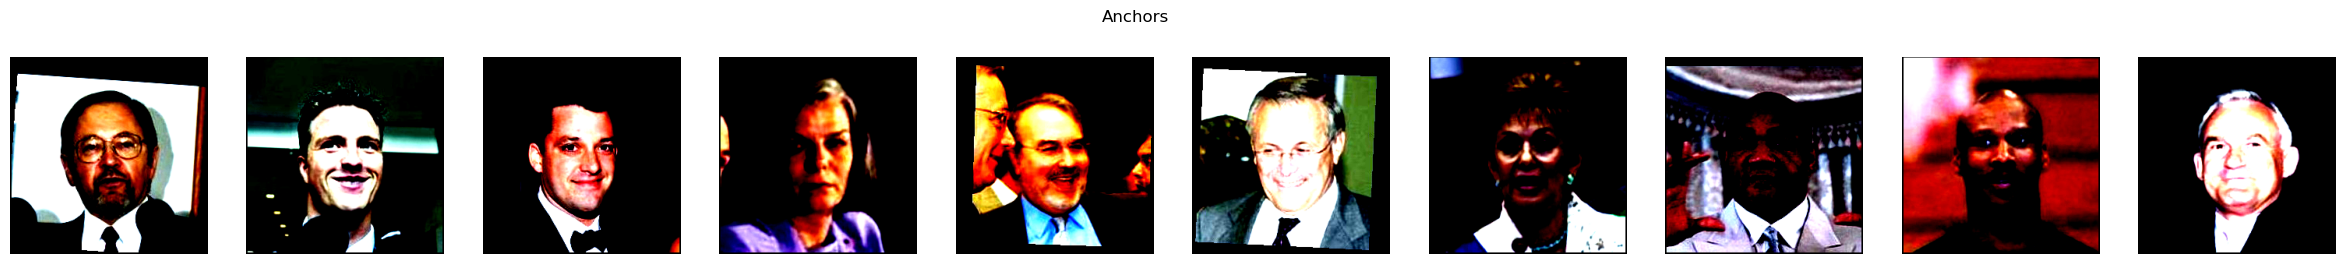

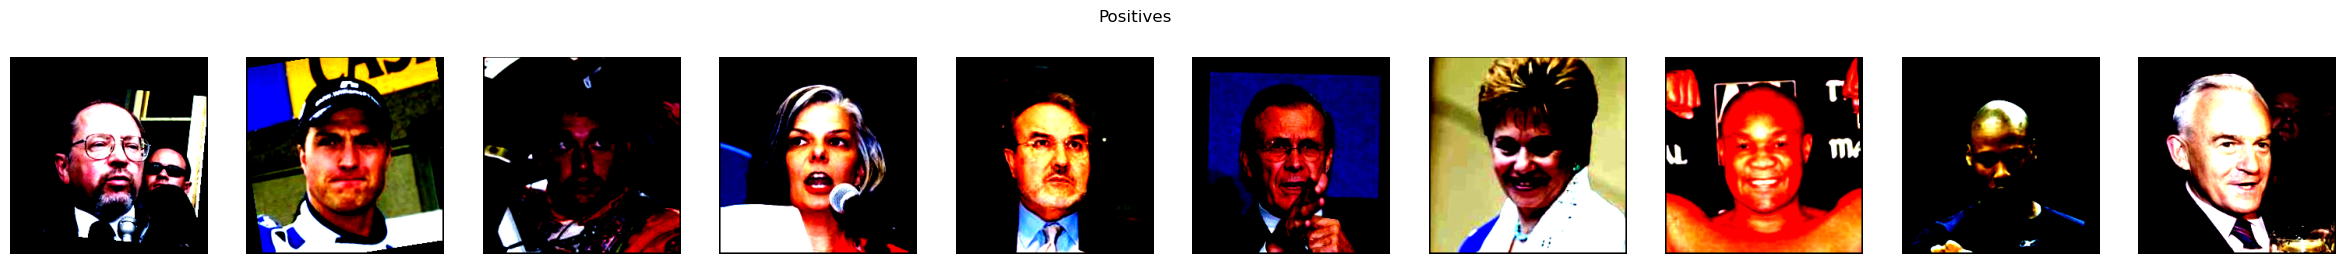

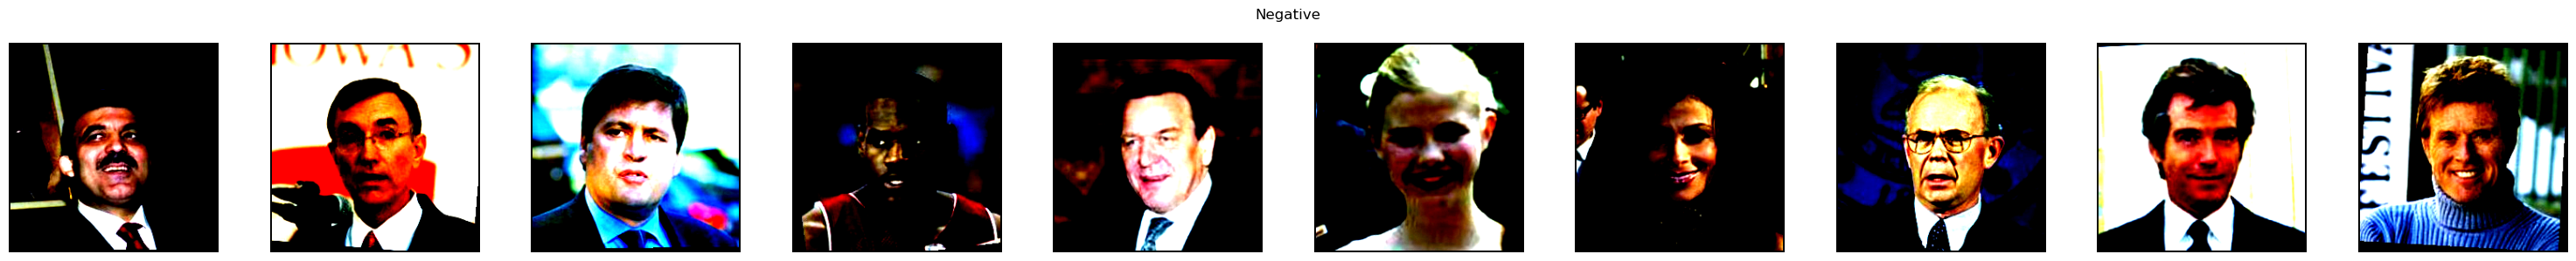

In [13]:
fig_anchors, anchors = plt.subplots(1, 10, figsize=(30,3))
fig_pos, positives = plt.subplots(1, 10, figsize=(30,3))
fig_neg, negatives = plt.subplots(1, 10, figsize=(30,3))
for i in range(10):
    try:
        (anchor, positive, negative), _ = tri_val_dataset[i]
        anchor = anchor.numpy().reshape(3,254,254).transpose(1, 2, 0)
        positive = positive.numpy().reshape(3,254,254).transpose(1, 2, 0)
        negative = negative.numpy().reshape(3,254,254).transpose(1, 2, 0)
        anchor = clip_img(anchor)
        positive = clip_img(positive)
        negative = clip_img(negative)
        anchors[i].imshow(anchor)
        anchors[i].axis("off")
        positives[i].imshow(positive)
        positives[i].axis("off")
        negatives[i].imshow(negative)
        negatives[i].axis("off")
    except ValueError:
        continue
fig_anchors.suptitle("Anchors")
fig_pos.suptitle("Positives")
fig_neg.suptitle("Negative")
plt.tight_layout()

In [14]:
batch_size = int(config["BATCH_SIZE"])

In [15]:
train_loader = torch.utils.data.DataLoader(dataset=tri_train_dataset, batch_size=batch_size, shuffle=True) 
valid_loader = torch.utils.data.DataLoader(dataset=tri_val_dataset, batch_size=batch_size, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=tri_test_dataset, batch_size=batch_size, shuffle=False) 

## Siamese model

In [11]:
class NormLayer(nn.Module):
    """ Layer that computer embedding normalization """
    def __init__(self, l=2):
        """ Layer initializer """
        assert l in [1, 2]
        super().__init__()
        self.l = l
        return
    
    def forward(self, x):
        """ Normalizing embeddings x. The shape of x is (B,D) """
        x_normalized = x / torch.norm(x, p=self.l, dim=-1, keepdim=True)
        return x_normalized

In [12]:
class SiameseModel(nn.Module):
    """ 
    Implementation of a simple siamese model 
    """
    def __init__(self, emb_dim=32, in_spatial=(32, 32), use_pretrained = True):
        """ Module initializer """
        super().__init__()
        
        # convolutional feature extractor
        resnet = models.resnet18(pretrained=use_pretrained)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        # fully connected embedder
        self.fc = nn.Linear(512, emb_dim)
        
        # auxiliar layers
        self.flatten = nn.Flatten()
        self.norm = NormLayer()
    
        return
    
    def forward_one(self, x):
        """ Forwarding just one sample through the model """
        x = self.resnet(x)
        x_flat = self.flatten(x)
        x_emb = self.fc(x_flat)
        x_emb_norm = self.norm(x_emb)
        return x_emb_norm
    
    def forward(self, anchor, positive, negative):
        """ Forwarding a triplet """
        anchor_emb = self.forward_one(anchor)
        positive_emb = self.forward_one(positive)
        negative_emb = self.forward_one(negative)
        
        return anchor_emb, positive_emb, negative_emb

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SiameseModel(use_pretrained = True)
model = model.to(device)

## Training
Triplet loss and Trainer shall initially remain unchanged

In [35]:
class TripletLoss(nn.Module):
    """ Implementation of the triplet loss function """
    def __init__(self, margin=0.2, reduce="mean"):
        """ Module initializer """
        assert reduce in ["mean", "sum"]
        super().__init__()
        self.margin = margin
        self.reduce = reduce
        return
        
    def forward(self, anchor, positive, negative):
        """ Computing pairwise distances and loss functions """
        # L2 distances
        d_ap = (anchor - positive).pow(2).sum(dim=-1)
        d_an = (anchor - negative).pow(2).sum(dim=-1)
        
        # triplet loss function
        loss = (d_ap - d_an + self.margin)
        loss = torch.maximum(loss, torch.zeros_like(loss))
        
        # averaging or summing      
        loss = torch.mean(loss) if(self.reduce == "mean") else torch.sum(loss)
      
        return loss

In [14]:
class SemiHardTripletLoss(nn.Module):
    """ Implementation of the triplet loss function """
    def __init__(self, margin=0.2, reduce="mean"):
        """ Module initializer """
        assert reduce in ["mean", "sum"]
        super().__init__()
        self.margin = margin
        self.reduce = reduce
        return
        
    def forward(self, anchor, positive, negative):
        """ Computing pairwise distances and loss functions """
        # L2 distances
        d_ap = (anchor - positive).pow(2).sum(dim=-1)
        d_an = (anchor - negative).pow(2).sum(dim=-1)
        
        # semi-hard negative mining
        mask = d_an < d_ap + self.margin
        hard_negatives = d_an[mask]
        
        # triplet loss function
        loss = (d_ap[mask] - hard_negatives + self.margin)
        loss = torch.maximum(loss, torch.zeros_like(loss))
        
        # averaging or summing      
        loss = torch.mean(loss) if(self.reduce == "mean") else torch.sum(loss)
      
        return loss

In [15]:
# class SemiHardTripletDataset:
#     """
#     Dataset class from which we sample random triplets
#     """
#     def __init__(self, dataset, model, margin  = 0.2):
#         """ Dataset initializer"""
#         self.dataset = dataset
#         self.arange = np.arange(len(self.dataset))
#         self.labels = torch.Tensor([l for _,l in dataset])
        
#         self.cleaned_dataset, self.cleaned_labels = self._clean_singular_anchors()
#         self.arange_cleaned = np.arange(len(self.cleaned_dataset))

#         self.embedding_model = model
#         self.margin = margin
#         return
    
#     def __len__(self):
#         """ Returning number of anchors """
#         return len(self.cleaned_dataset)
    
#     def _clean_singular_anchors(self):
#         """ This method cleans the dataset. It deletes the samples, in which there was only one face (cannot create positive and anchor faces).
#         """
#         singular_anchors = []
#         for i in range(len(self.dataset)):
#             _ , anchor_lbl = self.dataset[i]
#             pos_ids = self.arange[torch.where(self.labels == anchor_lbl)]
#             if isinstance(pos_ids, np.int64):
#                 singular_anchors.append(i)

#         self.cleaned_dataset = [self.dataset[i] for i in range(len(self.dataset)) if i not in singular_anchors]
#         self.cleaned_labels = torch.Tensor([l for _,l in self.cleaned_dataset])

#         return self.cleaned_dataset, self.cleaned_labels
    
#     def __getitem__(self, i):
#         """ 
#         Sampling a triplet for the dataset. Index i corresponds to anchor 
#         """
#         # sampling anchor
#         anchor_img, anchor_lbl = self.cleaned_dataset[i]
        
        
#         # lists for positives and negatives
#         pos_ids = self.arange_cleaned[torch.where(self.cleaned_labels == anchor_lbl)]
#         neg_ids = self.arange[torch.where(self.labels != anchor_lbl)]
#         pos_ids = np.delete(pos_ids, 0) # Deleting anchor face from the positive faces. Anchor id is always at the beggining of an array.

#         # Calculate instance, such that neg_distance to anchor is larger than pos_distance
#         # This is horribly inefficient, considering we do not use batch wise operations
#         with torch.no_grad():
#             self.model = self.model.eval()
#             for pos_id in pos_ids:
#                 positive, pos_lbl = self.cleaned_dataset[pos_id]
#                 for neg_id in neg_ids:
#                     negative, neg_lbl  = self.dataset[neg_id]
#                     # L2 distances
#                     d_ap = (anchor_img - positive).pow(2).sum(dim=-1)
#                     d_an = (anchor - negative).pow(2).sum(dim=-1)
                    
#                     if d_an > d_ap and d_an < self.margin:
#                         return (anchor_img, positive, negative), (anchor_lbl, pos_lbl, neg_lbl)


            

#         self.model = self.model.train()

#         print("No triplet could be found")
#         pos_id, neg_id = random.choice(pos_ids).item(), random.choice(neg_ids).item()
#         pos_img, pos_lbl = self.cleaned_dataset[pos_id] 
#         neg_img, neg_lbl = self.dataset[neg_id]
              
#         return (anchor_img, pos_img, neg_img), (anchor_lbl, pos_lbl, neg_lbl)

In [36]:
class Trainer:
    """
    Class for training and validating a siamese model
    """
    
    def __init__(self, model, criterion, train_loader, valid_loader, n_iters=1e4, save_freq = 500, margin = 0.2, save_name='siamese'):
        """ Trainer initializer """
        self.model = model
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        
        self.n_iters = int(n_iters)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        self.save_name = save_name
        self.margin = 0.2
        self.save_freq = save_freq
        self.train_loss = []
        self.valid_loss = []
        return
    
    @torch.no_grad()
    def valid_step(self, val_iters=100):
        """ Some validation iterations """
        self.model.eval()
        cur_losses = []
        for i, ((anchors, positives, negatives),_) in enumerate(self.valid_loader):   
            # setting inputs to GPU
            anchors = anchors.to(self.device)
            positives = positives.to(self.device)
            negatives = negatives.to(self.device)
            
            # forward pass and triplet loss
            anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
            loss = self.criterion(anchor_emb, positive_emb, negative_emb)
            cur_losses.append(loss.item())
            
            if(i >= val_iters):
                break
    
        self.valid_loss += cur_losses
        self.model.train()
        
        return cur_losses
    
    def fit(self):
        """ Train/Validation loop """
        
        self.iter_ = 0
        progress_bar = tqdm(total=self.n_iters, initial=0)
        
        for i in range(self.n_iters):
            for (anchors, positives, negatives), _ in self.train_loader:    
                # setting inputs to GPU
                anchors = anchors.to(self.device)
                positives = positives.to(self.device)
                negatives = negatives.to(self.device)
                
                # forward pass and triplet loss
                anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
                loss = self.criterion(anchor_emb, positive_emb, negative_emb)
                self.train_loss.append(loss.item())
                
                # optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
                # updating progress bar
                progress_bar.set_description(f"Train Iter {self.iter_}: Loss={round(loss.item(),5)})")
                
                # doing some validation every once in a while
                if(self.iter_ % 250 == 0):
                    cur_losses = self.valid_step()
                    print(f"Valid loss @ iteration {self.iter_}: Loss={np.mean(cur_losses)}")
                # saving model every n-th iter
                if(self.iter_ % self.save_freq == 0):
                    stats = {
                    "train_loss": self.train_loss,
                    "valid_loss": self.valid_loss
                    }
                    utils_v2.save_model(self.model, self.optimizer, self.iter_, stats, margin=self.margin, name=self.save_name)
                self.iter_ = self.iter_+1 
                if(self.iter_ >= self.n_iters):
                    break
            if(self.iter_ >= self.n_iters):
                break
        return

In [37]:
criterion = TripletLoss(margin=0.2)

In [38]:
trainer = Trainer(model=model, criterion=criterion, train_loader=train_loader, valid_loader=valid_loader, n_iters=10001, save_freq = 500, save_name = 'rand_weights')
# train_loader_semihard = torch.utils.data.DataLoader(dataset=tri_train_dataset, batch_size=128, shuffle=True) 

In [25]:
torch.cuda.empty_cache()

In [26]:
trainer.fit()

Train Iter 0: Loss=0.18298):   0%|                                                            | 0/10001 [00:00<?, ?it/s]

Valid loss @ iteration 0: Loss=0.18848027371697956


Train Iter 250: Loss=0.06728):   0%|                                                          | 0/10001 [01:18<?, ?it/s]

Valid loss @ iteration 250: Loss=0.0877341702580452


Train Iter 500: Loss=0.07092):   0%|                                                          | 0/10001 [02:36<?, ?it/s]

Valid loss @ iteration 500: Loss=0.08240800040463607


Train Iter 750: Loss=0.05015):   0%|                                                          | 0/10001 [03:55<?, ?it/s]

Valid loss @ iteration 750: Loss=0.0542634352006846


Train Iter 1000: Loss=0.04306):   0%|                                                         | 0/10001 [05:14<?, ?it/s]

Valid loss @ iteration 1000: Loss=0.05247866093284554


Train Iter 1250: Loss=0.04647):   0%|                                                         | 0/10001 [06:33<?, ?it/s]

Valid loss @ iteration 1250: Loss=0.04992129632996188


Train Iter 1500: Loss=0.06558):   0%|                                                         | 0/10001 [07:51<?, ?it/s]

Valid loss @ iteration 1500: Loss=0.05132972024795082


Train Iter 1750: Loss=0.02675):   0%|                                                         | 0/10001 [09:10<?, ?it/s]

Valid loss @ iteration 1750: Loss=0.0407945244676537


Train Iter 2000: Loss=0.01943):   0%|                                                         | 0/10001 [10:29<?, ?it/s]

Valid loss @ iteration 2000: Loss=0.049131515332394175


Train Iter 2250: Loss=0.01841):   0%|                                                         | 0/10001 [11:47<?, ?it/s]

Valid loss @ iteration 2250: Loss=0.04262610224799977


Train Iter 2500: Loss=0.02802):   0%|                                                         | 0/10001 [13:06<?, ?it/s]

Valid loss @ iteration 2500: Loss=0.04660612096389135


Train Iter 2750: Loss=0.00933):   0%|                                                         | 0/10001 [14:25<?, ?it/s]

Valid loss @ iteration 2750: Loss=0.03795945251153575


Train Iter 3000: Loss=0.01446):   0%|                                                         | 0/10001 [15:44<?, ?it/s]

Valid loss @ iteration 3000: Loss=0.03623617931993471


Train Iter 3250: Loss=0.0153):   0%|                                                          | 0/10001 [17:02<?, ?it/s]

Valid loss @ iteration 3250: Loss=0.043613200127664536


Train Iter 3500: Loss=0.0279):   0%|                                                          | 0/10001 [18:21<?, ?it/s]

Valid loss @ iteration 3500: Loss=0.04567055367968149


Train Iter 3750: Loss=0.00408):   0%|                                                         | 0/10001 [19:40<?, ?it/s]

Valid loss @ iteration 3750: Loss=0.038411445553518005


Train Iter 4000: Loss=0.0345):   0%|                                                          | 0/10001 [20:58<?, ?it/s]

Valid loss @ iteration 4000: Loss=0.04353515234672361


Train Iter 4250: Loss=0.01401):   0%|                                                         | 0/10001 [22:17<?, ?it/s]

Valid loss @ iteration 4250: Loss=0.03709736274969247


Train Iter 4500: Loss=0.00571):   0%|                                                         | 0/10001 [23:36<?, ?it/s]

Valid loss @ iteration 4500: Loss=0.03625079839386874


Train Iter 4750: Loss=0.00583):   0%|                                                         | 0/10001 [24:54<?, ?it/s]

Valid loss @ iteration 4750: Loss=0.030865147037224636


Train Iter 5000: Loss=0.01634):   0%|                                                         | 0/10001 [26:13<?, ?it/s]

Valid loss @ iteration 5000: Loss=0.03567508370098141


Train Iter 5250: Loss=0.01681):   0%|                                                         | 0/10001 [27:32<?, ?it/s]

Valid loss @ iteration 5250: Loss=0.03865519642002053


Train Iter 5500: Loss=0.00066):   0%|                                                         | 0/10001 [28:51<?, ?it/s]

Valid loss @ iteration 5500: Loss=0.03505982934600777


Train Iter 5750: Loss=0.00626):   0%|                                                         | 0/10001 [30:10<?, ?it/s]

Valid loss @ iteration 5750: Loss=0.030481335810489125


Train Iter 6000: Loss=0.00882):   0%|                                                         | 0/10001 [31:28<?, ?it/s]

Valid loss @ iteration 6000: Loss=0.036306358977324434


Train Iter 6250: Loss=0.00615):   0%|                                                         | 0/10001 [32:47<?, ?it/s]

Valid loss @ iteration 6250: Loss=0.04027760272017784


Train Iter 6500: Loss=0.00877):   0%|                                                         | 0/10001 [34:06<?, ?it/s]

Valid loss @ iteration 6500: Loss=0.0342954931806566


Train Iter 6750: Loss=0.00927):   0%|                                                         | 0/10001 [35:24<?, ?it/s]

Valid loss @ iteration 6750: Loss=0.0259921175117294


Train Iter 7000: Loss=0.03761):   0%|                                                         | 0/10001 [36:43<?, ?it/s]

Valid loss @ iteration 7000: Loss=0.03367182477894756


Train Iter 7250: Loss=0.00408):   0%|                                                         | 0/10001 [38:02<?, ?it/s]

Valid loss @ iteration 7250: Loss=0.03464208706282079


Train Iter 7500: Loss=0.00289):   0%|                                                         | 0/10001 [39:21<?, ?it/s]

Valid loss @ iteration 7500: Loss=0.03021225092622141


Train Iter 7750: Loss=0.00684):   0%|                                                         | 0/10001 [40:39<?, ?it/s]

Valid loss @ iteration 7750: Loss=0.036438975379698806


Train Iter 8000: Loss=0.00354):   0%|                                                         | 0/10001 [41:58<?, ?it/s]

Valid loss @ iteration 8000: Loss=0.03167275329016977


Train Iter 8250: Loss=0.00277):   0%|                                                         | 0/10001 [43:17<?, ?it/s]

Valid loss @ iteration 8250: Loss=0.030155479157757428


Train Iter 8500: Loss=0.0):   0%|                                                             | 0/10001 [44:36<?, ?it/s]

Valid loss @ iteration 8500: Loss=0.03579683700162503


Train Iter 8750: Loss=0.00514):   0%|                                                         | 0/10001 [45:54<?, ?it/s]

Valid loss @ iteration 8750: Loss=0.02324725268408656


Train Iter 9000: Loss=0.01416):   0%|                                                         | 0/10001 [47:13<?, ?it/s]

Valid loss @ iteration 9000: Loss=0.03669469581089086


Train Iter 9250: Loss=0.00419):   0%|                                                         | 0/10001 [48:31<?, ?it/s]

Valid loss @ iteration 9250: Loss=0.034646085256503686


Train Iter 9500: Loss=0.01846):   0%|                                                         | 0/10001 [49:50<?, ?it/s]

Valid loss @ iteration 9500: Loss=0.026932341201851766


Train Iter 9750: Loss=0.00709):   0%|                                                         | 0/10001 [51:09<?, ?it/s]

Valid loss @ iteration 9750: Loss=0.02309145766776055


Train Iter 10000: Loss=0.0032):   0%|                                                         | 0/10001 [52:30<?, ?it/s]

Valid loss @ iteration 10000: Loss=0.034615072421729565


In [16]:
@torch.no_grad()
def test_model(model, test_loader, criterion, device = "cuda"):
    """ Some test iterations """
    model.eval()
    cur_losses = []
    for i, ((anchors, positives, negatives),_) in enumerate(test_loader):   
        # setting inputs to GPU
        anchors = anchors.to(device)
        positives = positives.to(device)
        negatives = negatives.to(device)
        
        # forward pass and triplet loss
        anchor_emb, positive_emb, negative_emb = model(anchors, positives, negatives)
        loss = criterion(anchor_emb, positive_emb, negative_emb)
        cur_losses.append(loss.item())
    return np.mean(cur_losses)

## Random weights; embed_size=32; margin=0.2

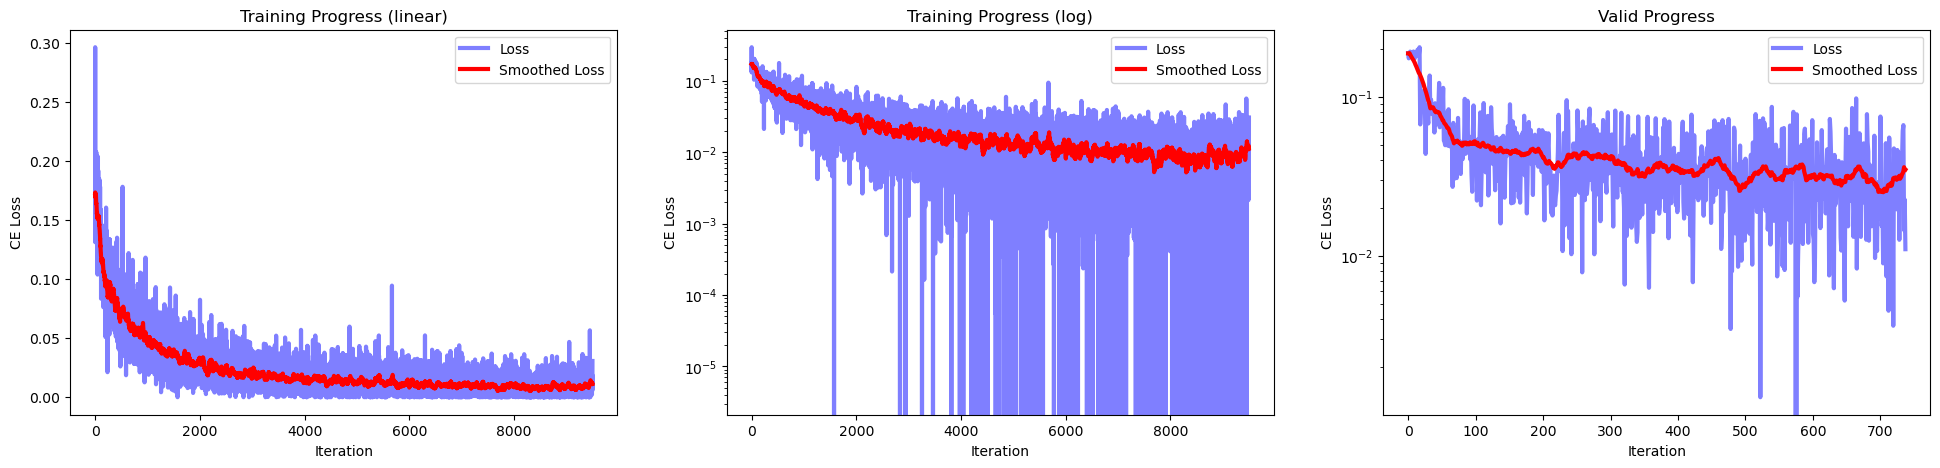

In [28]:
utils_v2.visualize_progress(trainer.train_loss[:9500], trainer.valid_loss[:9500], start=0)

In [32]:
print(f"Loss for the test set: {test_model(trainer.model, test_loader, criterion, device)}")

Loss for the test set: 0.04594797717736048


## Training finetuned (pretrained weights); embed_size=32; margin=0.2

In [39]:
model, optimizer, epoch, stats = utils_v2.load_model(trainer.model, trainer.optimizer, savepath="checkpoints/checkpoint_epoch_9500_margin_0.2.pth")

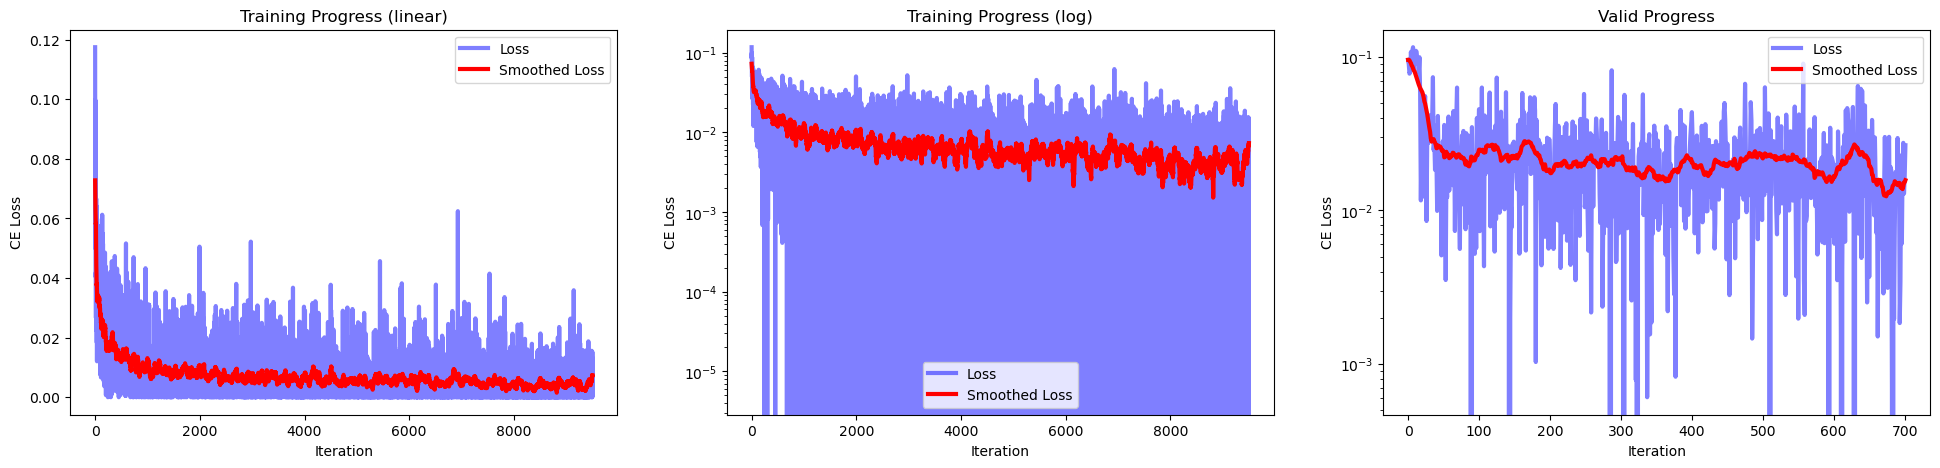

In [25]:
utils_v2.visualize_progress(stats["train_loss"], stats["valid_loss"], start=0)

In [40]:
print(f"Loss for the test set: {test_model(model, test_loader, criterion, device)}")

Loss for the test set: 0.017512838678764336


In the training progress plot, we can see that loss more often that not is equal to 0 (that's why blue loss curve drops all the way down). This is a good sign of training, because it states that positive samples are within the margin and negative ones are outside the margin, thus faces are correctly classified

## Semi-hard training of a better model

In [17]:
class SemiHardTrainer:
    """
    Class for training and validating a siamese model
    """
    
    def __init__(self, model, criterion, train_loader, valid_loader, n_iters=1e4, save_freq = 500, margin = 0.2, save_name='siamese'):
        """ Trainer initializer """
        self.model = model
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        
        self.n_iters = int(n_iters)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        self.save_name = save_name
        self.margin = 0.2
        self.save_freq = save_freq
        self.train_loss = []
        self.valid_loss = []
        return
    
    @torch.no_grad()
    def valid_step(self, val_iters=100):
        """ Some validation iterations """
        self.model.eval()
        cur_losses = []
        for i, ((anchors, positives, negatives), _) in enumerate(self.valid_loader):   
            # setting inputs to GPU
            anchors = anchors.to(self.device)
            positives = positives.to(self.device)
            negatives = negatives.to(self.device)
            # labels = torch.cat((anchor_lbls, pos_lbls, neg_lbls), dim=0)
            # forward pass and triplet loss
            anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
            # all_embeddings = torch.cat((anchor_emb, positive_emb, negative_emb), dim=0)
            hardest_positive_dist, hardest_negative_dist, hardest_negative_emb = self.get_triplets(anchor_emb, positive_emb, negative_emb)
            loss = self.criterion(anchor_emb, positive_emb, hardest_negative_emb)
            cur_losses.append(loss.item())
            
            if(i >= val_iters):
                break
    
        self.valid_loss += cur_losses
        self.model.train()
        
        return cur_losses
    def get_triplets(self, anchor_emb, positive_emb, negative_emb):
        """
        Function to generate triplets based on semi-hard negative mining strategy.
        """
        # pdb.set_trace()
        # Calculate pairwise distances in embedding space
        pairwise_dist = torch.cdist(anchor_emb, anchor_emb, p=2)

        # For each anchor-positive pair, compute the distance
        anchor_positive_dist = (anchor_emb - positive_emb).pow(2).sum(dim=-1)

        # Compute a mask for all hard negatives
        mask_hard_negative = pairwise_dist < (anchor_positive_dist.unsqueeze(1) + self.margin) # "+ self.margin" makes it semi-hard negative mining. 

        # For each anchor, find the hardest negative
        anchor_negative_dist = pairwise_dist + 1e6 * (1 - mask_hard_negative.float())
        hardest_negative_dist, hardest_negative = anchor_negative_dist.min(1, keepdim=True)

        # Get the embeddings of the hardest negatives
        hardest_negative_emb = negative_emb[hardest_negative.squeeze()]

        return anchor_positive_dist, hardest_negative_dist, hardest_negative_emb
    def fit(self):
        """ Train/Validation loop """
        
        self.iter_ = 0
        progress_bar = tqdm(total=self.n_iters, initial=0)
        
        for i in range(self.n_iters):
            for (anchors, positives, negatives), _ in self.train_loader:    
                # setting inputs to GPU
                anchors = anchors.to(self.device)
                positives = positives.to(self.device)
                negatives = negatives.to(self.device)
                # labels = torch.cat((anchor_lbls, pos_lbls, neg_lbls), dim=0)
                # forward pass and triplet loss
                anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
                # all_embeddings = torch.cat((anchor_emb, positive_emb, negative_emb), dim=0)
                hardest_positive_dist, hardest_negative_dist, hardest_negative_emb = self.get_triplets(anchor_emb, positive_emb, negative_emb)
                loss = self.criterion(anchor_emb, positive_emb, hardest_negative_emb)
                self.train_loss.append(loss.item())
                
                # optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
                # updating progress bar
                progress_bar.set_description(f"Train Iter {self.iter_}: Loss={round(loss.item(),5)})")
                
                # doing some validation every once in a while
                if(self.iter_ % 250 == 0):
                    cur_losses = self.valid_step()
                    print(f"Valid loss @ iteration {self.iter_}: Loss={np.mean(cur_losses)}")
                # saving model every n-th iter
                if(self.iter_ % self.save_freq == 0):
                    stats = {
                    "train_loss": self.train_loss,
                    "valid_loss": self.valid_loss
                    }
                    utils_v2.save_model(self.model, self.optimizer, self.iter_, stats, margin=self.margin, name=self.save_name)
                self.iter_ = self.iter_+1 
                if(self.iter_ >= self.n_iters):
                    break
            if(self.iter_ >= self.n_iters):
                break
        return

In [26]:
# Have to redefine dataloaders because if the batch size is too small, there might not be enough negatives in a batch for the semi-hard condition to be satisfied.

In [18]:
train_loader = torch.utils.data.DataLoader(dataset=tri_train_dataset, batch_size=128, shuffle=True) 
valid_loader = torch.utils.data.DataLoader(dataset=tri_val_dataset, batch_size=128, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=tri_test_dataset, batch_size=128, shuffle=False) 

In [19]:
torch.cuda.empty_cache()

In [21]:
device = "cuda"
model = SiameseModel(use_pretrained = True) # w/pretrained was better
model = model.to(device)

/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
criterion = TripletLoss(margin=0.2) # changed criterion
trainer_shard = SemiHardTrainer(model=model, criterion=criterion, train_loader=train_loader, valid_loader=valid_loader, n_iters=4001, save_freq = 500, save_name = 'semihard_6k') #only 4k iters, because we load a model trained on 6k iters

In [ ]:
# trainer_shard.fit()

Train Iter 0: Loss=0.13788):   0%|                                                            | 0/10001 [00:01<?, ?it/s]

Valid loss @ iteration 0: Loss=0.09063652157783508


Train Iter 250: Loss=0.00511):   0%|                                                          | 0/10001 [03:52<?, ?it/s]

Valid loss @ iteration 250: Loss=0.02135220542550087


Train Iter 500: Loss=0.01076):   0%|                                                          | 0/10001 [07:37<?, ?it/s]

Valid loss @ iteration 500: Loss=0.022602517985635333


Train Iter 750: Loss=0.00991):   0%|                                                          | 0/10001 [10:24<?, ?it/s]

Valid loss @ iteration 750: Loss=0.02349506618662013


Train Iter 1000: Loss=0.00489):   0%|                                                         | 0/10001 [13:01<?, ?it/s]

Valid loss @ iteration 1000: Loss=0.020588884647521708


Train Iter 1250: Loss=0.00647):   0%|                                                         | 0/10001 [15:34<?, ?it/s]

Valid loss @ iteration 1250: Loss=0.02026232647606068


Train Iter 1500: Loss=0.00661):   0%|                                                         | 0/10001 [18:08<?, ?it/s]

Valid loss @ iteration 1500: Loss=0.016210711819844112


Train Iter 1750: Loss=0.00351):   0%|                                                         | 0/10001 [20:40<?, ?it/s]

Valid loss @ iteration 1750: Loss=0.023578124172571633


Train Iter 2000: Loss=0.00669):   0%|                                                         | 0/10001 [23:17<?, ?it/s]

Valid loss @ iteration 2000: Loss=0.01844892981979582


Train Iter 2250: Loss=0.00445):   0%|                                                         | 0/10001 [25:59<?, ?it/s]

Valid loss @ iteration 2250: Loss=0.01874490516881148


Train Iter 2500: Loss=0.0076):   0%|                                                          | 0/10001 [28:29<?, ?it/s]

Valid loss @ iteration 2500: Loss=0.0183661917431487


Train Iter 2750: Loss=0.00522):   0%|                                                         | 0/10001 [31:00<?, ?it/s]

Valid loss @ iteration 2750: Loss=0.01731345026443402


Train Iter 3000: Loss=0.00585):   0%|                                                         | 0/10001 [33:29<?, ?it/s]

Valid loss @ iteration 3000: Loss=0.015684681116706796


Train Iter 3250: Loss=0.01159):   0%|                                                         | 0/10001 [35:59<?, ?it/s]

Valid loss @ iteration 3250: Loss=0.02159149820605914


Train Iter 3500: Loss=0.00896):   0%|                                                         | 0/10001 [38:28<?, ?it/s]

Valid loss @ iteration 3500: Loss=0.01431333382303516


Train Iter 3750: Loss=0.0108):   0%|                                                          | 0/10001 [40:59<?, ?it/s]

Valid loss @ iteration 3750: Loss=0.016293713202079136


Train Iter 4000: Loss=0.00646):   0%|                                                         | 0/10001 [43:28<?, ?it/s]

Valid loss @ iteration 4000: Loss=0.01614203490316868


Train Iter 4250: Loss=0.00747):   0%|                                                         | 0/10001 [45:59<?, ?it/s]

Valid loss @ iteration 4250: Loss=0.013425455066478915


Train Iter 4500: Loss=0.0021):   0%|                                                          | 0/10001 [48:29<?, ?it/s]

Valid loss @ iteration 4500: Loss=0.010784317351256808


Train Iter 4750: Loss=0.0008):   0%|                                                          | 0/10001 [50:59<?, ?it/s]

Valid loss @ iteration 4750: Loss=0.011344489253436526


Train Iter 5000: Loss=0.02006):   0%|                                                         | 0/10001 [53:28<?, ?it/s]

Valid loss @ iteration 5000: Loss=0.03348888705174128


Train Iter 5250: Loss=0.00845):   0%|                                                         | 0/10001 [55:58<?, ?it/s]

Valid loss @ iteration 5250: Loss=0.03173380365802182


Train Iter 5500: Loss=0.0039):   0%|                                                          | 0/10001 [58:27<?, ?it/s]

Valid loss @ iteration 5500: Loss=0.020204066919783752


Train Iter 5750: Loss=0.0009):   0%|                                                        | 0/10001 [1:00:58<?, ?it/s]

Valid loss @ iteration 5750: Loss=0.014078977698874142


Train Iter 6000: Loss=0.00602):   0%|                                                       | 0/10001 [1:03:27<?, ?it/s]

Valid loss @ iteration 6000: Loss=0.013521834535317289


Train Iter 6076: Loss=0.00078):   0%|                                                       | 0/10001 [1:04:16<?, ?it/s]

In [23]:
# resuming training, since my PC crashed lmao
model, optimizer, epoch, stats = utils_v2.load_model(trainer_shard.model, trainer_shard.optimizer, savepath="checkpoints/checkpoint_semihard_epoch_6000_margin_0.2.pth")


In [24]:
trainer_shard.train_loss = stats["train_loss"]
trainer_shard.valid_loss = stats["valid_loss"]
trainer_shard.model = model
trainer_shard.optimizer = optimizer

In [25]:
trainer_shard.fit()

Train Iter 0: Loss=0.00109):   0%|                                                             | 0/4001 [00:01<?, ?it/s]

Valid loss @ iteration 0: Loss=0.016303581444339618


Train Iter 250: Loss=0.00058):   0%|                                                           | 0/4001 [02:30<?, ?it/s]

Valid loss @ iteration 250: Loss=0.012939626118168235


Train Iter 500: Loss=0.00034):   0%|                                                           | 0/4001 [04:58<?, ?it/s]

Valid loss @ iteration 500: Loss=0.014275793917477131


Train Iter 750: Loss=0.0046):   0%|                                                            | 0/4001 [07:28<?, ?it/s]

Valid loss @ iteration 750: Loss=0.014303350096775426


Train Iter 1000: Loss=0.00268):   0%|                                                          | 0/4001 [09:57<?, ?it/s]

Valid loss @ iteration 1000: Loss=0.024401098696721926


Train Iter 1250: Loss=0.00302):   0%|                                                          | 0/4001 [12:27<?, ?it/s]

Valid loss @ iteration 1250: Loss=0.01377430252937807


Train Iter 1500: Loss=0.00507):   0%|                                                          | 0/4001 [14:56<?, ?it/s]

Valid loss @ iteration 1500: Loss=0.01369444839656353


Train Iter 1750: Loss=0.0054):   0%|                                                           | 0/4001 [17:26<?, ?it/s]

Valid loss @ iteration 1750: Loss=0.01789008325431496


Train Iter 2000: Loss=0.00522):   0%|                                                          | 0/4001 [19:55<?, ?it/s]

Valid loss @ iteration 2000: Loss=0.024799489312701754


Train Iter 2250: Loss=0.00175):   0%|                                                          | 0/4001 [22:25<?, ?it/s]

Valid loss @ iteration 2250: Loss=0.023583468256725207


Train Iter 2500: Loss=0.00077):   0%|                                                          | 0/4001 [24:54<?, ?it/s]

Valid loss @ iteration 2500: Loss=0.021194605363739863


Train Iter 2750: Loss=0.00746):   0%|                                                          | 0/4001 [27:24<?, ?it/s]

Valid loss @ iteration 2750: Loss=0.016660725697875023


Train Iter 3000: Loss=0.00013):   0%|                                                          | 0/4001 [29:53<?, ?it/s]

Valid loss @ iteration 3000: Loss=0.013356634066440165


Train Iter 3250: Loss=0.0):   0%|                                                              | 0/4001 [32:22<?, ?it/s]

Valid loss @ iteration 3250: Loss=0.01599674408013622


Train Iter 3500: Loss=0.00107):   0%|                                                          | 0/4001 [34:51<?, ?it/s]

Valid loss @ iteration 3500: Loss=0.016857331411706075


Train Iter 3750: Loss=0.00462):   0%|                                                          | 0/4001 [37:20<?, ?it/s]

Valid loss @ iteration 3750: Loss=0.016888266946706507


Train Iter 4000: Loss=0.00092):   0%|                                                          | 0/4001 [39:52<?, ?it/s]

Valid loss @ iteration 4000: Loss=0.0194724609868394


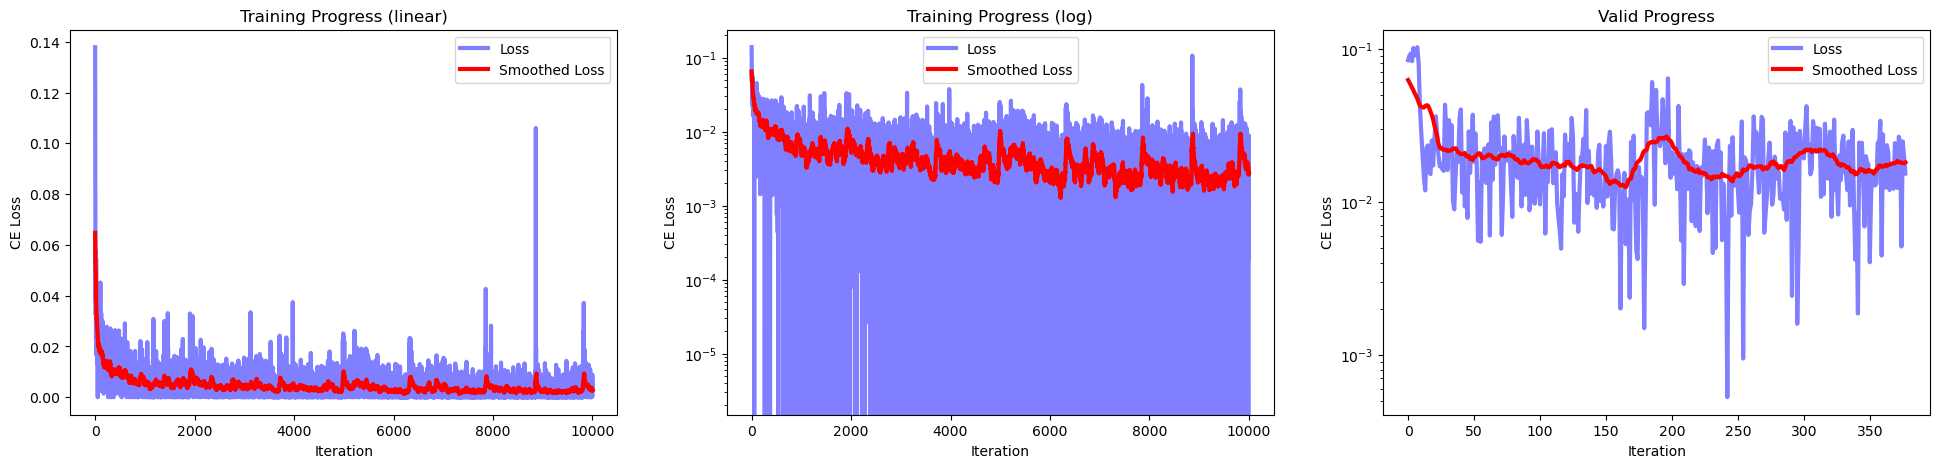

In [26]:
utils_v2.visualize_progress(trainer_shard.train_loss, trainer_shard.valid_loss, start=0)

In [27]:
print(f"Loss for the test set: {test_model(trainer_shard.model, test_loader, criterion, device)}")

Loss for the test set: 0.02015742550914486


We can see, that around 4500 iter/epoch, loss is at its lowest. Let's load and test the model, which was saved at 4500 iter

In [30]:
model_4500, optimizer_4500, epoch_4500, stats_4500 = utils_v2.load_model(trainer_shard.model, trainer_shard.optimizer, savepath="checkpoints/checkpoint_semihard_epoch_4500_margin_0.2.pth")

In [31]:
print(f"Loss for the test set: {test_model(model_4500, test_loader, criterion, device)}")

Loss for the test set: 0.01488266592948801


Test loss is even lower. It may be possible that after 4500 epoch, the model started overfitting, thus increasing valid loss

# Visualize Embeddings

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [27]:
# model = trainer.model
device = trainer.device
model = model.eval()

In [28]:
labels = torch.Tensor([l for _,l in test_dataset])
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [40]:
# test_dataset = datasets.LFWPeople(root='./data', transform=LFWPeople_tf, split="test",download=True)

# Filtering out labels, which occur more than k times in the test dataset
k = 25
max_label = int(torch.max(labels).item())
same_labels = []
same_tensors = []
for label in range(max_label):
    indices = torch.where(labels == label)
    if len(indices[0]) > k:
        selected_tensors = [test_dataset[i][0] for i in indices[0]]
        selected_tensors_labels = [test_dataset[i][1] for i in indices[0]]
        same_tensors.append(torch.stack(selected_tensors))
        same_labels += selected_tensors_labels
    
embeddings = [model.forward_one(same_tensors[i].to(device)).cpu().detach() for i in range(len(same_tensors))]
imgs_flat = torch.cat(same_tensors).flatten().cpu().detach()

print(np.unique(same_labels).__len__())

--Return--
None
> /tmp/ipykernel_880076/3590680231.py(6)<module>()
      4 k = 40
      5 max_label = int(torch.max(labels).item())
----> 6 pdb.set_trace()
      7 same_labels = []
      8 same_tensors = []



ipdb>  n


    [... skipped 1 hidden frame]

> /home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3529)run_code()
   3527             finally:
   3528                 # Reset our crash handler in place
-> 3529                 sys.excepthook = old_excepthook
   3530         except SystemExit as e:
   3531             if result is not None:



ipdb>  n


    [... skipped 1 hidden frame]

> /home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3550)run_code()
   3548             self.showtraceback(running_compiled_code=True)
   3549         else:
-> 3550             outflag = False
   3551         return outflag
   3552 



ipdb>  n


    [... skipped 1 hidden frame]

> /home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3551)run_code()
   3549         else:
   3550             outflag = False
-> 3551         return outflag
   3552 
   3553     # For backwards compatibility



ipdb>  n


    [... skipped 1 hidden frame]

Internal StopIteration: False
> /home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3466)run_ast_nodes()
   3464                     code = compiler(mod, cell_name, mode)
   3465                     asy = compare(code)
-> 3466                 if await self.run_code(code, result, async_=asy):
   3467                     return True
   3468 



ipdb>  n


> /home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3454)run_ast_nodes()
   3452                 to_run.append((node, "single"))
   3453 
-> 3454             for node, mode in to_run:
   3455                 if mode == "exec":
   3456                     mod = Module([node], [])



ipdb>  n


> /home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3455)run_ast_nodes()
   3453 
   3454             for node, mode in to_run:
-> 3455                 if mode == "exec":
   3456                     mod = Module([node], [])
   3457                 elif mode == "single":



ipdb>  n


> /home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3456)run_ast_nodes()
   3454             for node, mode in to_run:
   3455                 if mode == "exec":
-> 3456                     mod = Module([node], [])
   3457                 elif mode == "single":
   3458                     mod = ast.Interactive([node])  # type: ignore



ipdb>  n


> /home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3459)run_ast_nodes()
   3457                 elif mode == "single":
   3458                     mod = ast.Interactive([node])  # type: ignore
-> 3459                 with compiler.extra_flags(
   3460                     getattr(ast, "PyCF_ALLOW_TOP_LEVEL_AWAIT", 0x0)
   3461                     if self.autoawait



ipdb>  n


> /home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3461)run_ast_nodes()
   3459                 with compiler.extra_flags(
   3460                     getattr(ast, "PyCF_ALLOW_TOP_LEVEL_AWAIT", 0x0)
-> 3461                     if self.autoawait
   3462                     else 0x0
   3463                 ):



ipdb>  n


> /home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3460)run_ast_nodes()
   3458                     mod = ast.Interactive([node])  # type: ignore
   3459                 with compiler.extra_flags(
-> 3460                     getattr(ast, "PyCF_ALLOW_TOP_LEVEL_AWAIT", 0x0)
   3461                     if self.autoawait
   3462                     else 0x0



ipdb>  exit


BdbQuit: 

In [33]:
visualization_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

embs = list()
labels = list()
imgs_flat = list()

with torch.no_grad():
    for data, label in visualization_loader:
        data = data.to(device)
        data_embedding = model.forward_one(data)

        labels.append(label)
        embs.append(data_embedding.cpu().flatten(1))
        imgs_flat.append(data.cpu().flatten(1))

labels = np.concatenate(labels)
embs = np.concatenate(embs)
imgs_flat = np.concatenate(imgs_flat)

In [34]:

assert 0 not in same_labels, "0 in same_labels change the label of the undefined cluster"

filtered_labels = [int(labels[i].item()) if labels[i] in same_labels else 0 for i in range(labels.__len__())]

In [35]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)
pca_embs = PCA(n_components=2).fit_transform(embs)

'''
pca_imgs_object = PCA(n_components=2).fit(imgs_flat)
pca_embs_object = PCA(n_components=2).fit(embs)
'''


'\npca_imgs_object = PCA(n_components=2).fit(imgs_flat)\npca_embs_object = PCA(n_components=2).fit(embs)\n'

In [36]:
np.unique(filtered_labels).__len__()

84

In [ ]:
def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    COLORS = ['grey', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'r',
              'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(i)], c=COLORS[i])
    ax.legend(loc="best")

/tmp/ipykernel_1519098/734107461.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


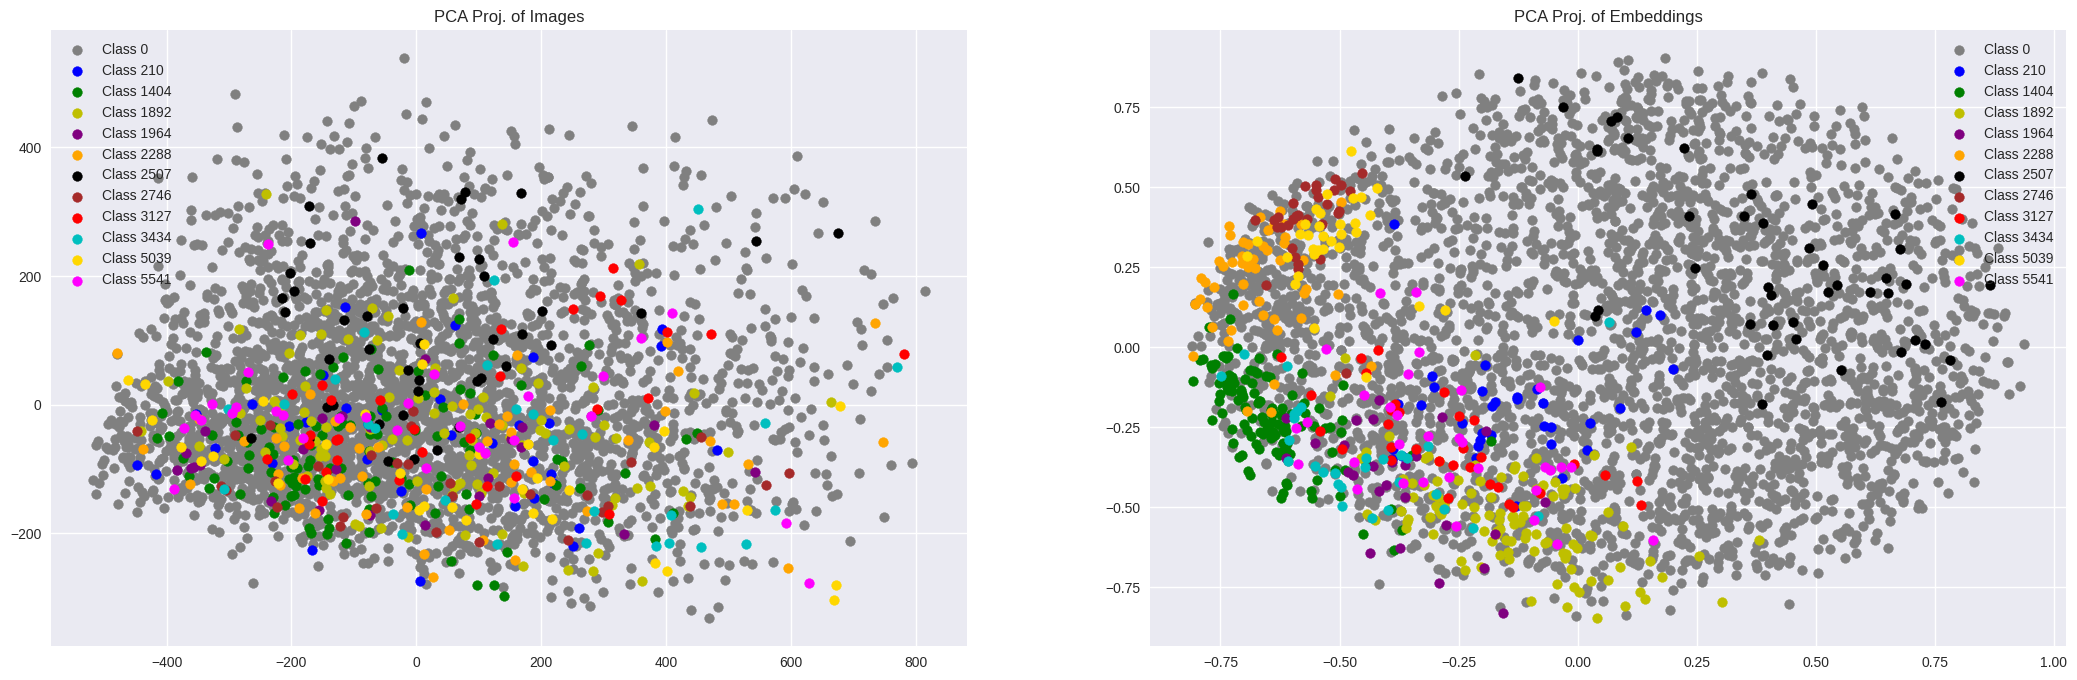

In [ ]:
N = 5000
plt.style.use('seaborn')
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], filtered_labels[:N], ax=ax[0])
ax[0].set_title("PCA Proj. of Images")
display_projections(pca_embs[:N], filtered_labels[:N], ax=ax[1])
ax[1].set_title("PCA Proj. of Embeddings")
plt.show()

In [ ]:
N = 2000
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_embs = TSNE(n_components=2).fit_transform(embs[:N])

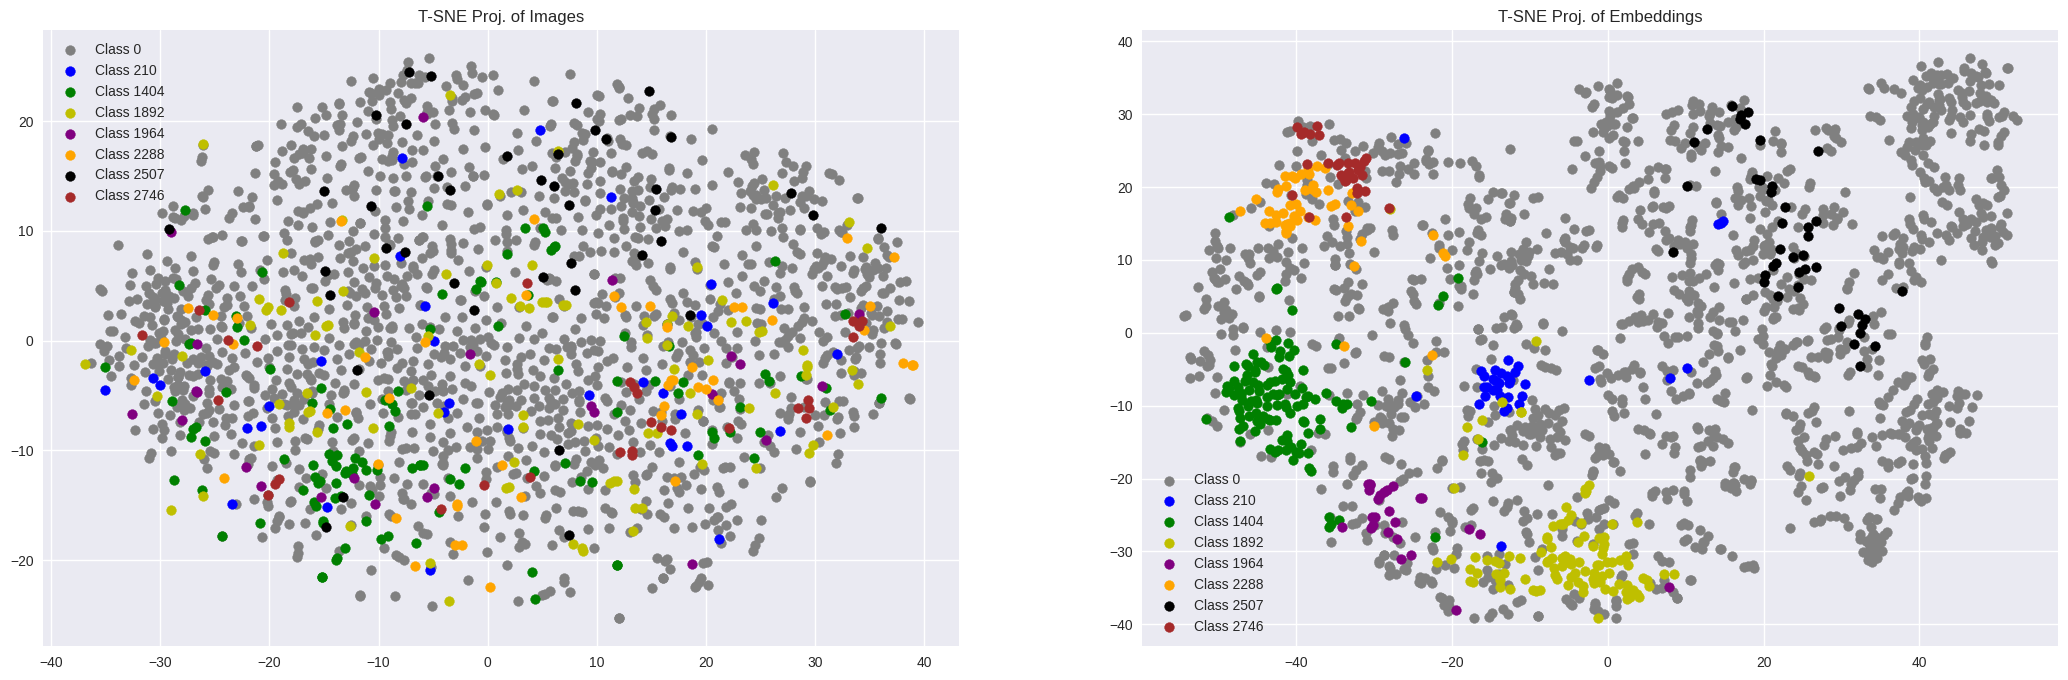

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], filtered_labels[:N], ax=ax[0])
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_embs[:N], filtered_labels[:N], ax=ax[1])
ax[1].set_title("T-SNE Proj. of Embeddings")
plt.show()

In [ ]:

# This code is not needed anymore
'''
def display_projections_no_labels(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
              'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)
        ax.scatter(points[idx, 0], points[idx, 1])
    ax.legend(loc="best")

    

labels = torch.Tensor([l for _,l in test_dataset])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_label = int(torch.max(labels).item())

same_labels = []
same_tensors = []
for label in range(max_label):
    indices = torch.where(labels == label)
    if len(indices[0]) > 10:
        selected_tensors = [test_dataset[i][0] for i in indices[0]]
        selected_tensors_labels = [test_dataset[i][1] for i in indices [0]]
        same_tensors.append(torch.stack(selected_tensors))
        same_labels += selected_tensors_labels

embeddings = [model.forward_one(same_tensors[i].to(device)).cpu().detach() for i in range(len(same_tensors))]
imgs_flat = torch.concatenate(same_tensors, dim = 0).flatten(1).cpu().detach().numpy()

pca_imgs = pca_imgs_object.transform(imgs_flat)
pca_embs = pca_embs_object.transform(embs)

display_projections(pca_imgs, labels = same_labels)
display_projections(pca_embs, labels=same_labels)
'''

'\ndef display_projections_no_labels(points, labels, ax=None, legend=None):\n    """ Displaying low-dimensional data projections """\n    \n    COLORS = [\'r\', \'b\', \'g\', \'y\', \'purple\', \'orange\', \'k\', \'brown\', \'grey\',\n              \'c\', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]\n    \n    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend\n    if(ax is None):\n        _, ax = plt.subplots(1,1,figsize=(12,6))\n    \n    for i,l in enumerate(np.unique(labels)):\n        idx = np.where(l==labels)\n        ax.scatter(points[idx, 0], points[idx, 1])\n    ax.legend(loc="best")\n\n    \n\nlabels = torch.Tensor([l for _,l in test_dataset])\ndevice = \'cuda\' if torch.cuda.is_available() else \'cpu\'\nmax_label = int(torch.max(labels).item())\n\nsame_labels = []\nsame_tensors = []\nfor label in range(max_label):\n    indices = torch.where(labels == label)\n    if len(indices[0]) > 10:\n        selected_tensors = [test_dataset[i][0] 